# Compare Spectra with BG40

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 6th 2022
- last update : June  6th 2022 : Save in file


### 

    


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

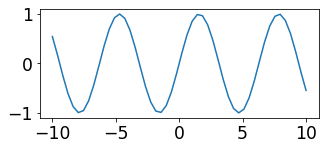

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-07'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)

## Dispersion relation X - wavelength
$$
x = D \frac{N_{eff} \lambda p}{\sqrt{1-(N_{eff} \lambda p)^2}}
$$

In [17]:
def Dispersion(wl,neff,D,p=1):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl*p/np.sqrt(1-(wl*neff*p)**2)
    return X


## Dispersion rate dX/d lambda
$$
\frac{dx}{d\lambda} = D N_{eff} p \frac{\sqrt{1-(N_{eff}\lambda p)^2} + \frac{(N_{eff} \lambda p)^2}{\sqrt{1-(N_{eff} \lambda p)^2} }}{1-(N_{eff} \lambda p)^2} 
$$

$$
\frac{dx}{d\lambda} = \frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}}} 
$$

In [18]:
def Dispersion_Rate(wl,neff,D,p=1):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    #dxdlambda=D*neff*p*(np.sqrt(1-(wl*neff*p)**2)+ (wl*neff*p)**2/np.sqrt(1-(wl*neff*p)**2))/(1-(wl*neff*p)**2)
    dxdlambda=D*neff*p/(np.sqrt(1-(wl*neff*p)**2))**3
    return dxdlambda 

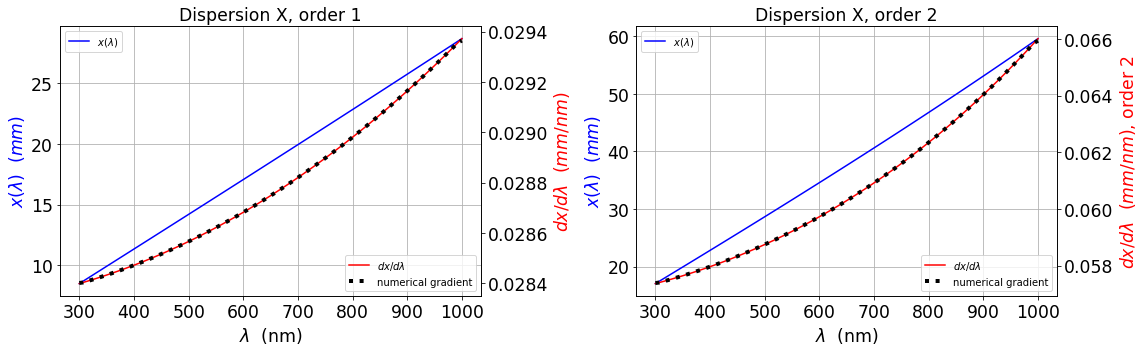

In [19]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

WL=np.linspace(300.,1000.,100)
neff=156. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X, order 1")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


ax3 = fig.add_subplot(1,2,2)

Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")
ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax3.set_title("Dispersion X, order 2")
ax3.legend(loc="upper left")
ax3.grid()


ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)*1e-6 ## mm per nm
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($mm/ nm$), order 2",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")
#ax2.grid()


plt.tight_layout()


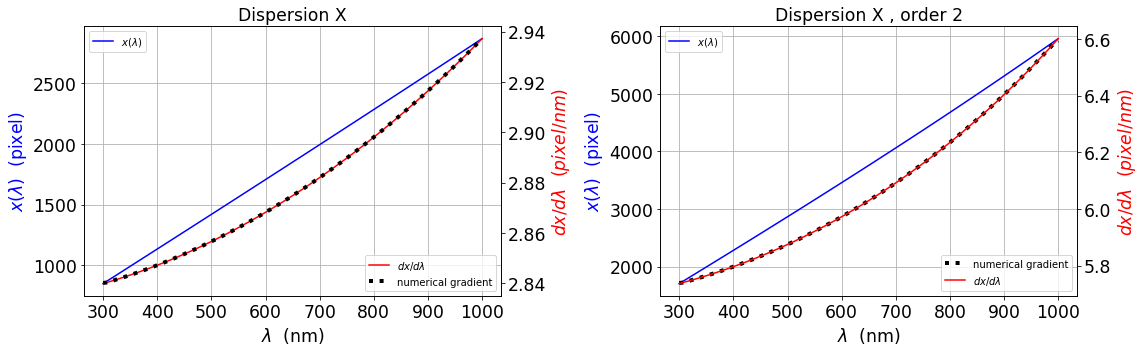

In [20]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()



ax3 = fig.add_subplot(1,2,2)


Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)/PIXELW   # pixel
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")

ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax3.set_title("Dispersion X , order 2")
ax3.legend(loc="upper left")
ax3.grid()

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)/PIXELW*1e-6   # pixel per nm
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")

plt.tight_layout()

## Multiplicative factor

$$
\frac{\left(\frac{dx}{d\lambda}\right)_{order =2}}{\left(\frac{dx}{d\lambda}\right)_{order =1}}
$$

Text(0.5, 1.0, 'Multiplicative factor order 2/order1 ')

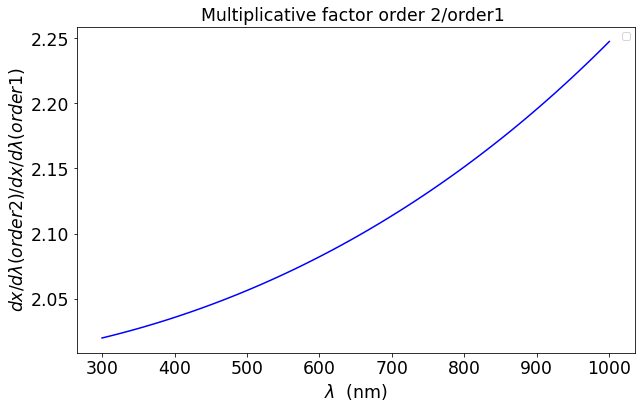

In [21]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,1,1)
latexlabel = "$\frac{\left(\frac{dx}{d\lambda}\right)_{order=2}}{\left(\frac{dx}{d\lambda}\right)_{order=1}}$"
ax1.plot(WL,Y4/Y2,"b-")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$dx/d\lambda(order2) / dx/d\lambda(order 1) $")
ax1.legend()
ax1.set_title("Multiplicative factor order 2/order1 ")

In [22]:
f_o2o1=interpolate.interp1d(WL,Y4/Y2,bounds_error=False,fill_value="extrapolate")

# Config

- spectrum need config

In [23]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [24]:
# path index for each month
DATE="20211104"

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [25]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D"

In [26]:
#! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104

In [27]:
#exposure = "2021110400263"  # HD905205
#exposure = "2021110400274"   # HD009051 , creazy results
#exposure ="2021110400508"  # ETADOR
#exposure = "2021110400519"  # HD38949
#exposure = "2021110400542"   # HD031128
#exposure = "2021110400553"    #Mu Col
#exposure = "2021110400564"   # HD38949

In [28]:
Exposure_to_target = {"2021110400263":"HD905205",
                     "2021110400274":"HD009051",
                     "2021110400508":"ETADOR",
                     "2021110400519":"HD38949",
                     "2021110400542":"HD031128",
                     "2021110400553":"Mu Col",
                     "2021110400564":"HD38949"}                     

In [29]:
list_of_exposures = list(Exposure_to_target.keys())
list_of_exposures

['2021110400263',
 '2021110400274',
 '2021110400508',
 '2021110400519',
 '2021110400542',
 '2021110400553',
 '2021110400564']

In [30]:
list_of_exposures_targets = list(Exposure_to_target.items())
list_of_exposures_targets

[('2021110400263', 'HD905205'),
 ('2021110400274', 'HD009051'),
 ('2021110400508', 'ETADOR'),
 ('2021110400519', 'HD38949'),
 ('2021110400542', 'HD031128'),
 ('2021110400553', 'Mu Col'),
 ('2021110400564', 'HD38949')]

In [31]:
all_fullpath = [ os.path.join(os.path.join(os.path.join(top_path,DATE),exposure),"basespec") for exposure in list_of_exposures]
all_fullpath 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400263/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400274/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400519/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400542/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400553/basespec',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400564/basespec']

## Read Spectra

In [32]:
!ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400263/basespec

exposure_2021110400263_postisrccd_lines.csv
exposure_2021110400263_postisrccd_spectrogram.fits
exposure_2021110400263_postisrccd_spectrum.fits
exposure_2021110400263_postisrccd_table.csv


In [33]:
all_spectra = []
for file_fullpath in all_fullpath: 
    list_of_files = sorted(os.listdir(file_fullpath))
    print(list_of_files)
    spectrum = Spectrum(os.path.join(file_fullpath,list_of_files[2]))
    all_spectra.append(spectrum)

['exposure_2021110400263_postisrccd_lines.csv', 'exposure_2021110400263_postisrccd_spectrogram.fits', 'exposure_2021110400263_postisrccd_spectrum.fits', 'exposure_2021110400263_postisrccd_table.csv']
set date_obs to 2021-11-05T01:43:31.722
set expo to 20.0
set airmass to 1.156770779362235
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -27.3065833333333
set hour_angle to 34.4454279916179
set temperature to 5.8
set pressure to 741.05
set humidity to 49.0
set lambda_ref to 571.8069014788438
set parallactic_angle to 103.8799996934361


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = HD205905, Selected object name for Simbad : HD205905
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 205905 21 39 10.1509 -27 18 23.662 ... -0.0000570                1
['exposure_2021110400274_postisrccd_lines.csv', 'exposure_2021110400274_postisrccd_spectrogram.fits', 'exposure_2021110400274_postisrccd_spectrum.fits', 'exposure_2021110400274_postisrccd_table.csv']
set date_obs to 2021-11-05T01:51:23.948
set expo to 20.0
set airmass to 1.06037825874769
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -24.3403888888889
set hour_angle to -20.93456535541785
set temperature to 5.9
set pressure to 741.1
set humidity to 47.0
set lambda_ref to 576.3774338842832
set parallactic_angle to -112.2644694071151
target_name = HD009051, Selected object name for Simbad : HD00

In [34]:
from spectractor.tools import plot_spectrum_simple

(0.0, 8e-11)

<Figure size 864x576 with 0 Axes>

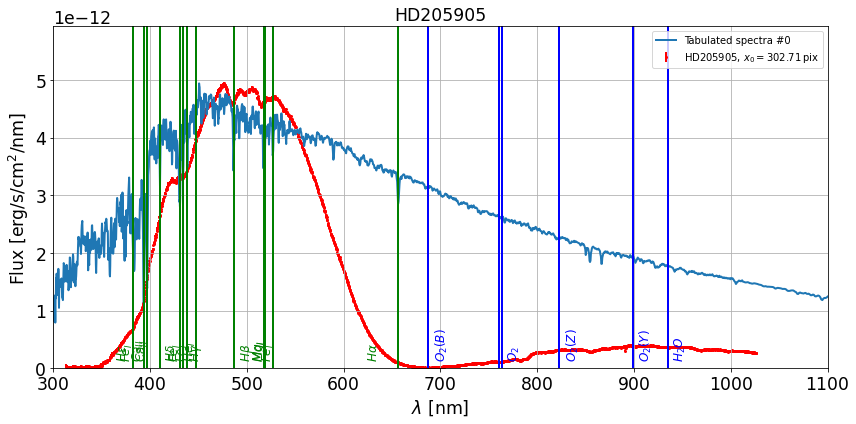

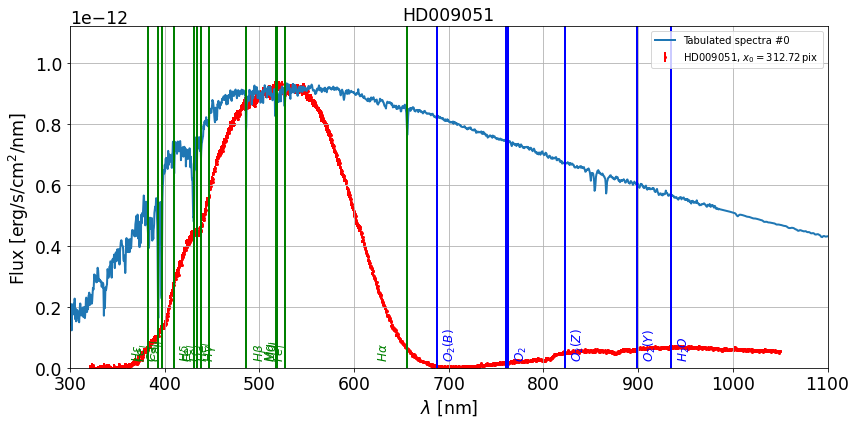

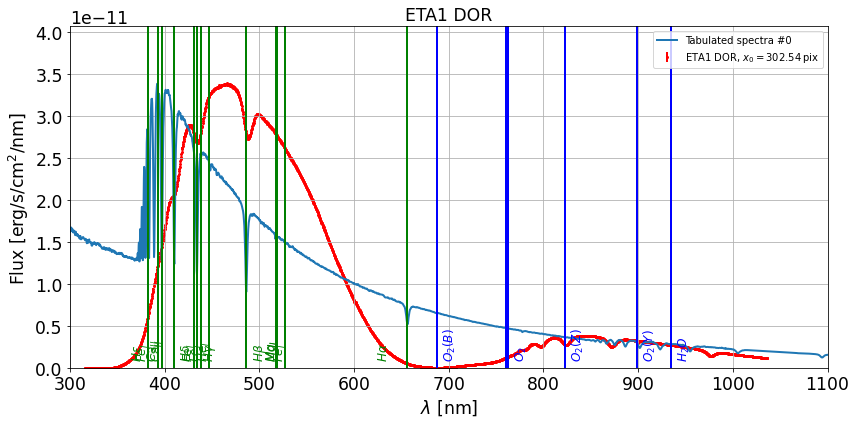

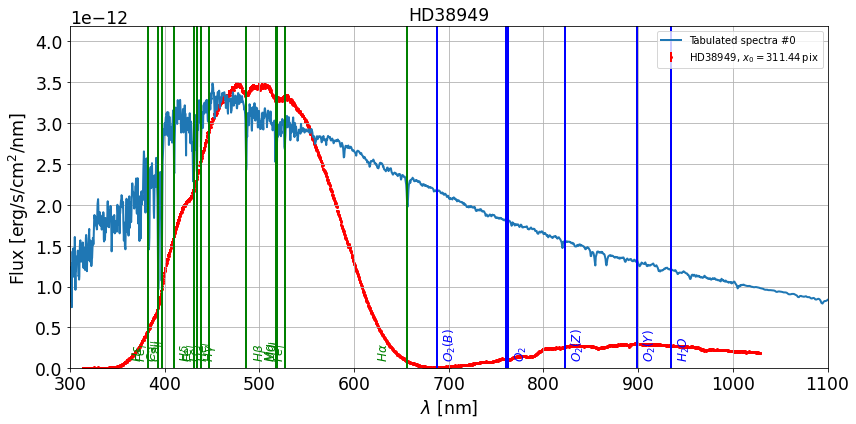

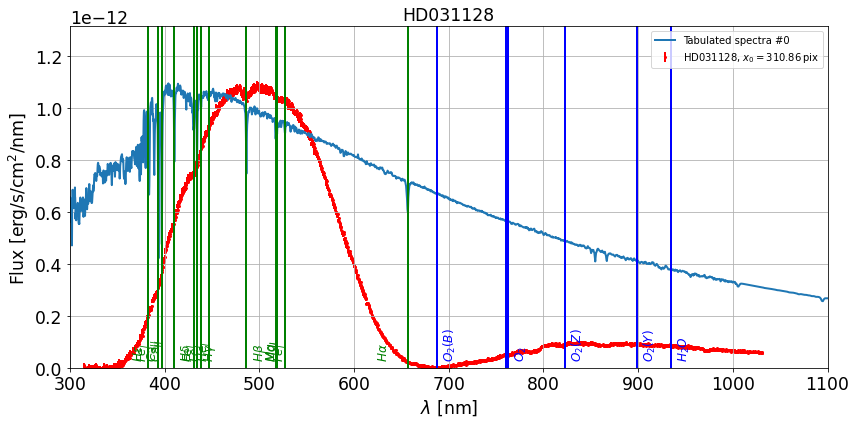

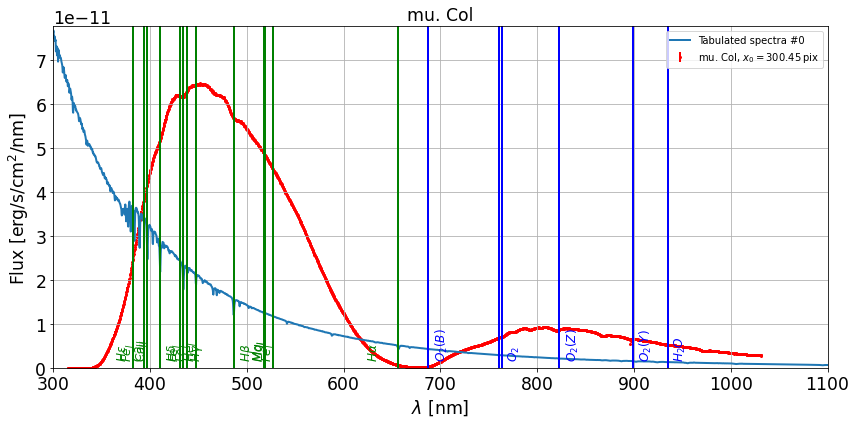

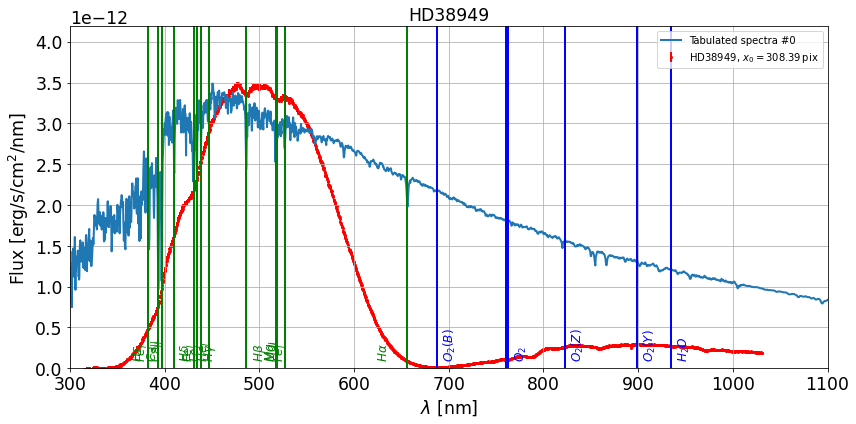

In [35]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.color_palette("hls", len(all_spectra))


for spectrum in all_spectra:
    spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=spectrum.target.label)
ax.set_ylim(0,0.8e-10)

(0.0, 8e-11)

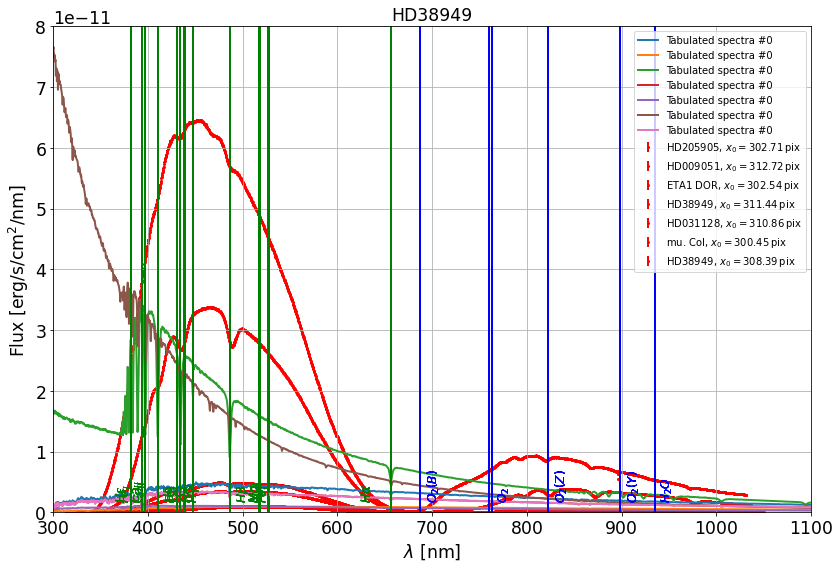

In [36]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

for spectrum in all_spectra:
    spectrum.plot_spectrum(ax=ax,xlim=[300,1100], live_fit=False, force_lines=True,label=spectrum.target.label)
ax.set_ylim(0,0.8e-10)

Text(0.5, 1.0, 'Fluxes through BG 40 ')

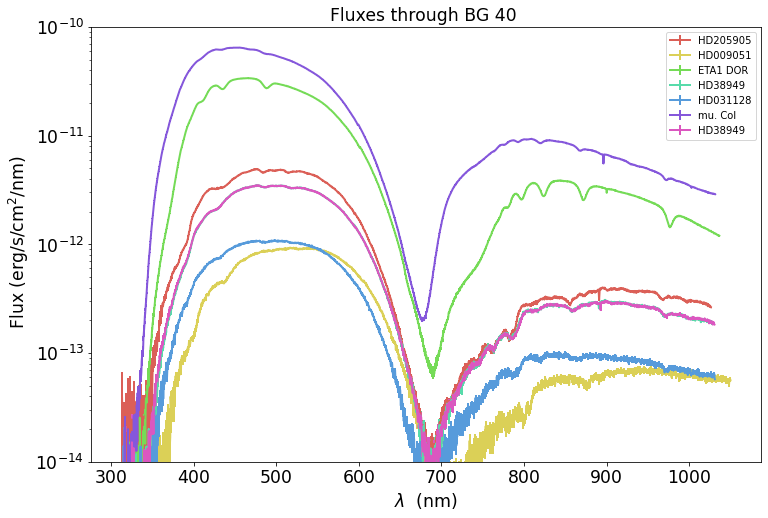

In [37]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
color_list = sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

idx=0
for spectrum in all_spectra:
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    idx+=1
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-14,1e-10)
ax.set_xlabel("$\lambda$  (nm)")
ax.set_ylabel(f" Flux ({spectrum.units})")
ax.set_title("Fluxes through BG 40 ")

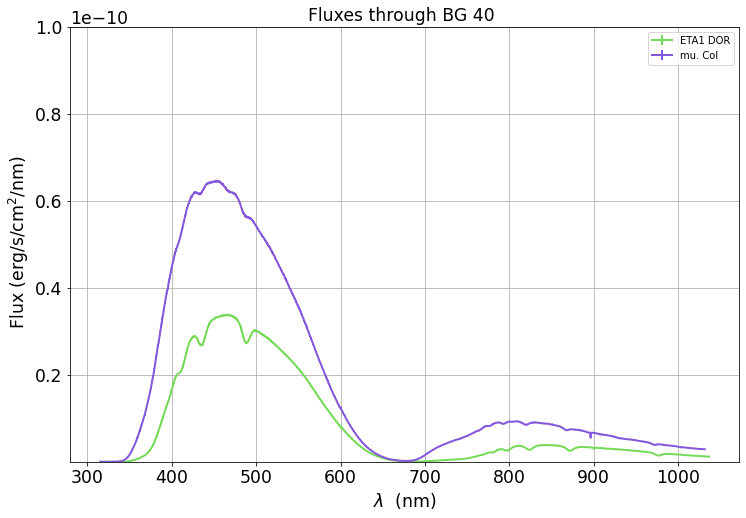

In [40]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
color_list = sns.color_palette("hls", len(all_spectra))
ax = fig.add_subplot(1,1,1)

idx=0
for spectrum in all_spectra:
    targetname = spectrum.target.label
    if targetname == "ETA1 DOR" or targetname == "mu. Col":
        ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    idx+=1
ax.legend()
#ax.set_yscale("log")
ax.set_ylim(1e-14,1e-10)
ax.set_xlabel("$\lambda$  (nm)")
ax.set_ylabel(f" Flux ({spectrum.units})")
ax.set_title("Fluxes through BG 40 ")
plt.grid()

In [ ]:
for spectrum in all_spectra:
    targetname = spectrum.target.label
    print(targetname)

    #if targetname == "ETA1 DOR":
    if targetname == "mu. Col":
        thespectrum = spectrum
        parameters.LAMBDA_MIN = 350.
        parameters.LAMBDA_MAX = 650.
        parameters.DEBUG   = True
        parameters.DISPLAY = True
        parameters.LIVE_FIT= True
        calibrate_spectrum(thespectrum, with_adr=False)

HD205905
HD009051
ETA1 DOR
HD38949
HD031128
mu. Col


2022-06-07 17:10:54  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


In [ ]:
thespectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,label=thespectrum.target.label)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
thespectrum.plot_spectrum(ax=ax,xlim=[300,1100], live_fit=False, force_lines=False,label=thespectrum.target.label)
thespectrum.lines.plot_detected_lines(ax=ax,print_table=True)